In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import functools
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, LinearRegression, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank, col
import pyspark.sql.functions as func
import matplotlib.pyplot as plt

In [2]:
spark_application_name = "Spark_Project_ML"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

22/06/01 13:42:03 WARN Utils: Your hostname, MacBook-Air-de-Hao.local resolves to a loopback address: 127.0.0.1; using 10.29.116.59 instead (on interface en0)
22/06/01 13:42:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/01 13:42:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
def get_data(path, schema, header=True, delimiter=';'):
    """Get datas from path

    Parameters
    ----------
    path : string
        file location
    schema : StructType
        Schema for dataframe
    header: bool
        Take the header or not, default True
    delimiter: 
        the delimiter of the input file, default ;
    Returns
    -------
        DataFrame
    """
    
    extension = path.split('.')[-1]
    if (extension == "csv"):
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    elif (extension == 'json'):
        df = spark.read.json(path, schema)
    else:
        # join all csv in a folder
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    return df

In [5]:
microsoft_path = 'stocks_data/MICROSOFT.csv'
amazon_path = 'stocks_data/AMAZON.csv'
zoom_path = 'stocks_data/ZOOM.csv'
facebook_path = 'stocks_data/FACEBOOK.csv'
apple_path = 'stocks_data/APPLE.csv'
google_path = 'stocks_data/GOOGLE.csv'
tesla_path = 'stocks_data/TESLA.csv'


stocksColumns = [StructField("Date",TimestampType()), StructField("High",DoubleType()), 
              StructField("Low",DoubleType()), StructField("Open",DoubleType()),
              StructField("Close",DoubleType()), StructField("Volume", DoubleType()), 
              StructField("Adj Close",DoubleType()), StructField("company_name", StringType())]

stocksSchema = StructType(stocksColumns)


microsoft = get_data(microsoft_path, stocksSchema, delimiter=',').drop(col("company_name"))
amazon = get_data(amazon_path, stocksSchema, delimiter=',').drop(col("company_name"))
zoom = get_data(zoom_path, stocksSchema, delimiter=',').drop(col("company_name"))
facebook = get_data(facebook_path, stocksSchema, delimiter=',').drop(col("company_name"))
apple = get_data(apple_path, stocksSchema, delimiter=',').drop(col("company_name"))
google = get_data(google_path, stocksSchema, delimiter=',').drop(col("company_name"))
tesla = get_data(tesla_path, stocksSchema, delimiter=',').drop(col("company_name"))

In [10]:
def Predict(df, forecast_days = 1, nLags = 1, estimator='LinearRegression',  column='Close'):
    """ Forecast stock price 

    Parameters
    ----------
    df : DataFrame
    
    forecast_days : Int
        Number of days for the forecasting, default 1
        
    nLags : Int
        Number of days used for the forecasting, default 1
        
    estimator : String
        The name of estimator, default LinearRegression. 
        Other possibility: DecisionTreeRegression, RandomForestRegressor, GBTRegressor
        
    column : String
        The column that we forecast
    
    Returns
    -------
        (predictions on train, prediction on test, rmse on train, rmse on test)
    """
    LeadWindow = Window.rowsBetween(0,forecast_days)
    df = df.withColumn("label", func.last(df["Close"]).over(LeadWindow))
    features = [column]
    df = df.withColumn("Series",func.lit('Univariate'))
    mywindow = Window.orderBy("Series")
    
    for i in range(nLags):
        strLag = column + '_LagBy_' + str(i+1)
        df = df.withColumn(strLag,func.lag(\
                   df[column], i+1).over(mywindow))
        features.append(strLag)
    
    df = df.drop("Series")
    df = df.dropna()
    vA = VectorAssembler().setInputCols(features).setOutputCol("features")
    df = vA.transform(df)
    
    # Train test split
    
    df = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("Date")))
    train_df = df.where("rank <= .8").drop("rank")
    test_df = df.where("rank > .8").drop("rank")
    
    # RMSE is used as evaluation metric
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName ="rmse")
    
    if (estimator == 'LinearRegression'):
        lr = LinearRegression(featuresCol = "features", labelCol="label", maxIter = 100, regParam = 0.4,elasticNetParam = 0.1)
        model = lr.fit(train_df)
        predictions_lr_test = model.transform(test_df)
        predictions_lr_train = model.transform(train_df)

        RMSE_lr_test= evaluator.evaluate(predictions_lr_test)
        RMSE_lr_train = evaluator.evaluate(predictions_lr_train)
        
        return (predictions_lr_train, predictions_lr_test, RMSE_lr_train, RMSE_lr_test)
    
    if (estimator == "DecisionTreeRegression"):
        dr = DecisionTreeRegressor(featuresCol = "features", labelCol = "label", maxDepth = 5)
        model = dr.fit(train_df)
        predictions_dr_test = model.transform(test_df)
        predictions_dr_train = model.transform(train_df)    

        RMSE_dr_test = evaluator.evaluate(predictions_dr_test)
        RMSE_dr_train = evaluator.evaluate(predictions_dr_train)
        
        return (predictions_dr_train, predictions_dr_test, RMSE_dr_train, RMSE_dr_test)
    
    if(estimator == 'RandomForestRegression'):
        rfr = RandomForestRegressor(featuresCol="features",labelCol="label",maxDepth = 5,subsamplingRate = 0.8)
        model = rfr.fit(train_df)
        predictions_rfr_test = model.transform(test_df)
        predictions_rfr_train = model.transform(train_df)
    
        RMSE_rfr_test= evaluator.evaluate(predictions_rfr_test)
        RMSE_rfr_train = evaluator.evaluate(predictions_rfr_train)
        
        return (predictions_rfr_train, predictions_rfr_test, RMSE_rfr_train, RMSE_rfr_test)
    
    if(estimator == 'GBTRegression'):
        gbt = GBTRegressor(featuresCol="features", labelCol="label", maxDepth=5, subsamplingRate=0.8)
        model = gbt.fit(train_df)
        predictions_gbt_test = model.transform(test_df)
        predictions_gbt_train = model.transform(train_df)
        
        RMSE_gbt_test= evaluator.evaluate(predictions_gbt_test)
        RMSE_gbt_train = evaluator.evaluate(predictions_gbt_train)
        
        return (predictions_gbt_train, predictions_gbt_test, RMSE_gbt_train, RMSE_gbt_test)

In [30]:
train, test, rmse_train, rmse_test = Predict(microsoft,  forecast_days = 1, nLags = 3, estimator="LinearRegression",  column='Close')

22/06/01 14:09:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 1

In [31]:
def plot_prediction(df):
    """ Plot the predict on train or test dataframe
    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    
    Date = [val for val in df.select('Date').collect()]
    label = [val for val in df.select('label').collect()]
    pred = [val for val in df.select('prediction').collect()]


    plt.figure(figsize=(20,10))
    plt.title("Stock price forcasting")
    plt.xlabel('Date') 
    plt.ylabel('price')

    plt.plot(Date, label, label= 'actual')
    plt.plot(Date, pred, label= 'prediction')

    plt.legend()
    plt.show()

22/06/01 14:09:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 14:09:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/01 1

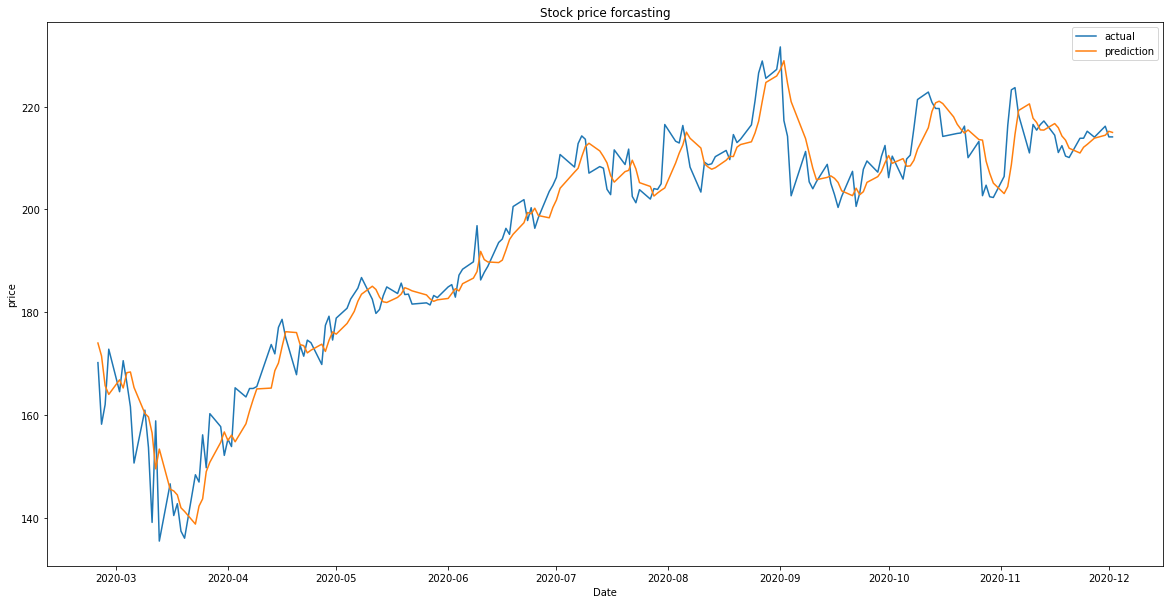

In [32]:
plot_prediction(test)

In [33]:
rmse_test

5.280537038844534

In [34]:
rmse_train

1.8050594886411795